In [1]:
import requests
import textacy
from functools import partial
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import textacy.tm
import warnings
import gensim
import gensim.downloader as api
import matplotlib
import time
import datetime
from collections import Counter
from gensim.models import KeyedVectors

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
model_glove_french = KeyedVectors.load_word2vec_format("frWiki_no_phrase_no_postag_700_cbow_cut100.bin",unicode_errors="ignore", binary=True )
model_glove_wiki = api.load("glove-wiki-gigaword-100")


In [3]:
lang = 'fr_core_news_lg'

In [4]:
df1 = pd.read_csv('tweets_1_tierslieux_19024.csv')
df1 = df1.sort_values(by=['timestamp_utc'], ascending=True,ignore_index=True)

df2 = pd.read_csv('tweets_2_tierslieu_6038.csv')
df2 = df2.sort_values(by=['timestamp_utc'], ascending=True,ignore_index=True)

df1.columns

Index(['query', 'id', 'timestamp_utc', 'local_time', 'user_screen_name',
       'text', 'possibly_sensitive', 'retweet_count', 'like_count',
       'reply_count', 'lang', 'to_username', 'to_userid', 'to_tweetid',
       'source_name', 'source_url', 'user_location', 'lat', 'lng', 'user_id',
       'user_name', 'user_verified', 'user_description', 'user_url',
       'user_image', 'user_tweets', 'user_followers', 'user_friends',
       'user_likes', 'user_lists', 'user_created_at', 'user_timestamp_utc',
       'collected_via', 'match_query', 'retweeted_id', 'retweeted_user',
       'retweeted_user_id', 'retweeted_timestamp_utc', 'quoted_id',
       'quoted_user', 'quoted_user_id', 'quoted_timestamp_utc',
       'collection_time', 'url', 'place_country_code', 'place_name',
       'place_type', 'place_coordinates', 'links', 'domains', 'media_urls',
       'media_files', 'media_types', 'mentioned_names', 'mentioned_ids',
       'hashtags', 'intervention_type', 'intervention_text',
       'in

In [5]:
df_combined = pd.DataFrame(columns=['id','text','hashtags','timestamp_utc','year','month','day'])

for temp_df in [df1,df2]:
    new_df = pd.DataFrame(columns=['id','text','hashtags','timestamp_utc','year','month','day'])
    for cols in ['id','text','hashtags','timestamp_utc']:
        new_df[cols] = temp_df[cols]

    date = pd.to_datetime(temp_df['timestamp_utc'], unit='s')
    new_df['year'] = pd.DatetimeIndex(date).year
    new_df['month'] = pd.DatetimeIndex(date).month
    new_df['day'] = pd.DatetimeIndex(date).day

    df_combined = pd.concat([df_combined,new_df])

df_combined = df_combined.drop_duplicates(ignore_index=True)
df_combined = df_combined.sort_values(by=['timestamp_utc'], ascending=True,ignore_index=True)

ori_hashtag = df_combined['hashtags']

for i, hasht in enumerate(ori_hashtag):
    temp_hasht = hasht.split('|')
    temp_hasht = [ht for ht in temp_hasht if ht!='tierslieux']
    temp_hasht = [ht for ht in temp_hasht if ht!='tierslieu']
    ori_hashtag[i] = temp_hasht

df_combined['hashtags'] = ori_hashtag
df_combined.to_csv('tweets_combined.csv')
df_combined

,id,text,hashtags,timestamp_utc,year,month,day
0,2408979548344320,"RT @fbon: La ""non bibliothèque"" de Chris Meade...",[],1289409320,2010,11,10
1,4884796241088512,"""Impact des nvx modes de travail [= #teletrava...",[teletravail],1289999600,2010,11,17
2,27334783331729408,#thirdplace #tierslieux #EnUnMot RT @hughpearm...,"[enunmot, thirdplace]",1295352094,2011,1,18
3,36102389715058688,observe les amoureux qui s'bécotent sur les ma...,[],1297442455,2011,2,11
4,43616655615594496,#Tierslieu#Aubervilliers http://sebastienlucas...,[tierslieu#aubervilliers],1299233995,2011,3,4
...,...,...,...,...,...,...,...
24940,1507396566138728451,#Dissay : le Barlu de Fortpuy lance sa saison ...,"[culture, dissay, ess]",1648226322,2022,3,25
24941,1507414436725800964,Rdv champêtre pour cette inauguration du #tier...,[vezelise],1648230582,2022,3,25
24942,1507455065879154703,@CommunsVdG @laMYNE_ @s_fredriksson Merci @s_f...,[],1648240269,2022,3,25
24943,1507665165352947717,💚Nous sommes à la @TourneeTL des #TiersLieux a...,"[citoyens, climat, communs]",1648290361,2022,3,26


In [6]:
years = list(np.unique(df_combined['year']))
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [7]:
year_topic_list_french, year_topic_list_wiki, year_tweet_num_list = ([] for x in range(3))
year_hashtag_list, year_hastag_num_list = ([] for x in range(2))

nlp = spacy.load('fr_core_news_lg')

for year in years:
    df_year = df_combined.copy(deep=True)
    df_year = df_year[df_year['year']==year]
    temp_documents = list(df_year['text'].str.lower())

    year_tweet_num_list.append(len(df_year))
    
    corpus = textacy.Corpus(lang)
    for item in ['parser']:
        if item in corpus.spacy_lang.pipe_names:
            corpus.spacy_lang.remove_pipe(item)

    corpus.add_texts(temp_documents) 

    docs_terms = (textacy.extract.terms(doc,ngs=partial(textacy.extract.ngrams, n=1, include_pos={"NOUN", "ADJ","VERB"}),ents=partial(textacy.extract.entities, include_types={ "ORG", "GPE", "LOC"}))for doc in corpus)
    tokenized_docs = (textacy.extract.terms_to_strings(doc_terms, by="lemma") for doc_terms in docs_terms)
    doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs,tf_type="linear", idf_type="smooth")
    id_to_term = {id_: term for term, id_ in vocab.items()}

    model = textacy.tm.TopicModel("nmf", n_topics=1, max_iter=5000)
    model.fit(doc_term_matrix)
    doc_topic_matrix = model.transform(doc_term_matrix)

    word_list = list(model.top_topic_terms(id2term=id_to_term,topics=[0],top_n=10))

    word_axis_french = np.zeros(shape=(700,))
    word_axis_wiki = np.zeros(shape=(100,))
    for k in range(len(word_list[0][1])):
        try:
            word_axis_wiki += model_glove_wiki.get_vector(word_list[0][1][k])
        except:
            pass

        try:
            word_axis_french += model_glove_french.get_vector(word_list[0][1][k])
        except:
            pass

    final_word_french = model_glove_french.most_similar(positive=[word_axis_french], topn=5)  
    final_word_wiki = model_glove_wiki.most_similar(positive=[word_axis_wiki], topn=5)  

    year_topic_list_french.append(final_word_french)
    year_topic_list_wiki.append(final_word_wiki)

    print(f'year {year}')
    # print("Year "+str(year)+" topic : '"+final_word[0][0]+"' with probability: "+str(np.round(final_word[0][1],2)))

year 2010
year 2011
year 2012
year 2013
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022


In [16]:
year_topic_list_wiki_final = [tp[0][0] if tp[0][0]!='=' else 'nouveau' for tp in year_topic_list_wiki]
year_topic_list_french_final = [tp[0][0] if tp[0][0]!='>' else tp[1][0] for tp in year_topic_list_french]
year_topic_list_french_final

['immobilier',
 'télétravail',
 'télétravail',
 'télétravail',
 'télétravail',
 'télétravail',
 'innovation',
 'innovation',
 'numérique',
 'espace',
 'numérique',
 'numérique',
 'espace']

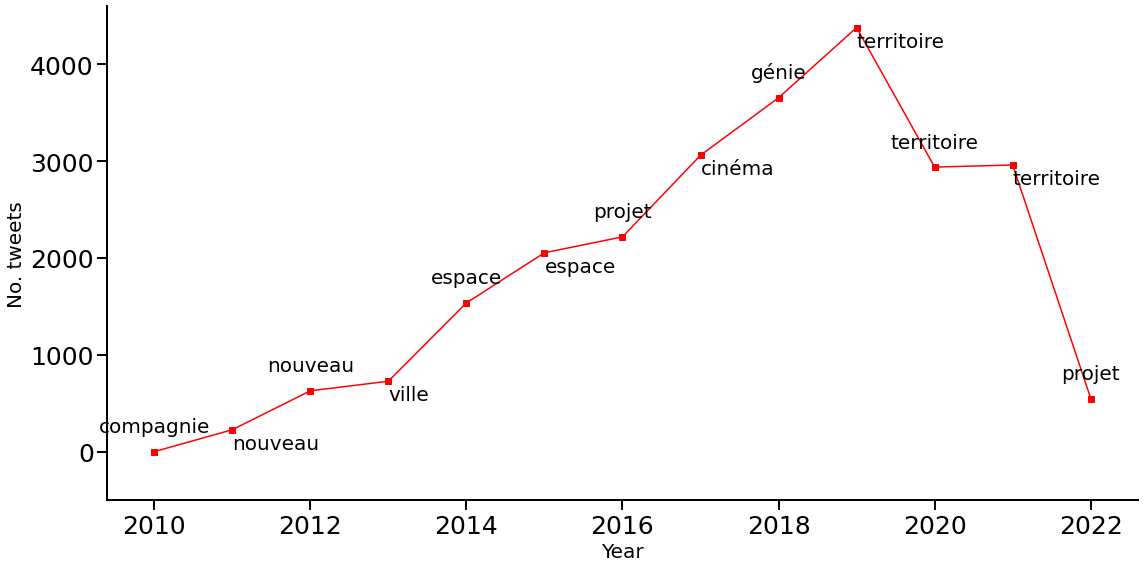

In [26]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years,year_tweet_num_list,color='r',marker='s')

shift_ver = 200
shift_hor = 0.0
for i,year in enumerate(years):
    if i%2 == 0:
        ax.text(year-shift_hor,year_tweet_num_list[i]+shift_ver,year_topic_list_wiki_final[i],fontsize=20,ha='center')
    else:
        ax.text(year+shift_hor,year_tweet_num_list[i]-shift_ver,year_topic_list_wiki_final[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('No. tweets',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-500)

plt.tight_layout()
plt.savefig('tweets_topic_time_wiki.jpeg', dpi=100)

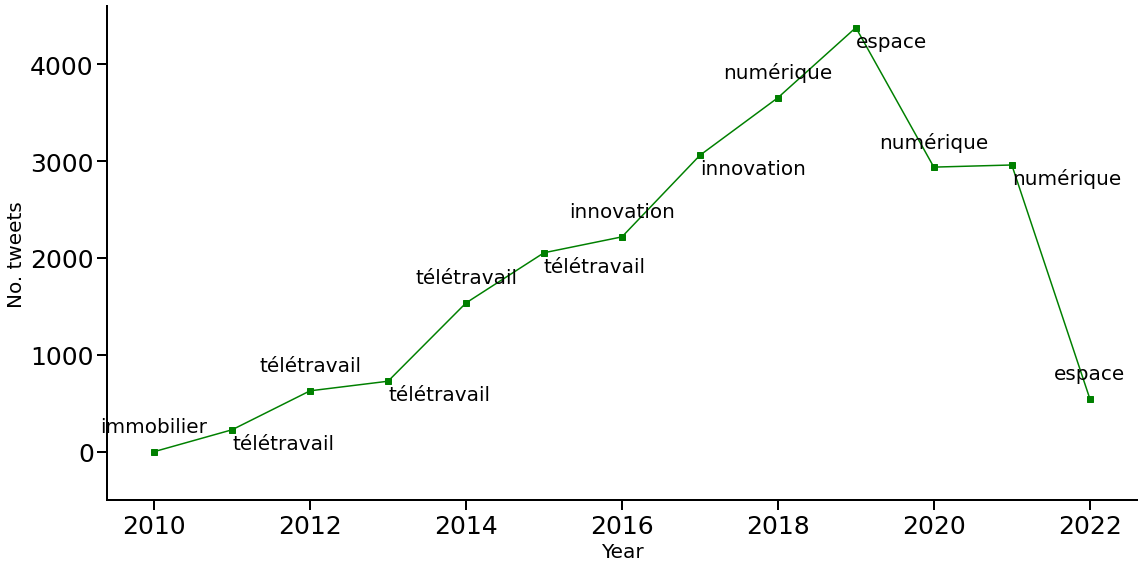

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years,year_tweet_num_list,color='g',marker='s')

shift_ver = 200
shift_hor = 0.0
for i,year in enumerate(years):
    if i%2 == 0:
        ax.text(year-shift_hor,year_tweet_num_list[i]+shift_ver,year_topic_list_french_final[i],fontsize=20,ha='center')
    else:
        ax.text(year+shift_hor,year_tweet_num_list[i]-shift_ver,year_topic_list_french_final[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('No. tweets',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-500)

plt.tight_layout()
plt.savefig('tweets_topic_time_french.jpeg', dpi=100)

In [27]:
year_hashtag1_list, year_hashtag1_num_list = ([] for x in range(2))
year_hashtag2_list, year_hashtag2_num_list = ([] for x in range(2))

for year in years[1:]:
    df_year = df_combined.copy(deep=True)
    df_year = df_year[df_year['year']==year]
    
    ################ HASHTAG ANALYSIS ###############################
    temp_hashtag = list(df_year['hashtags'])
    temp_hashtag = [item for sublist in temp_hashtag for item in sublist]
    temp_hashtag_dict = Counter(temp_hashtag)
    temp_hashtag_sort = sorted(temp_hashtag_dict.items(),key=(lambda i: i[1]))

    year_hashtag1_list.append(temp_hashtag_sort[-1][0])
    year_hashtag1_num_list.append(temp_hashtag_sort[-1][1])

    year_hashtag2_list.append(temp_hashtag_sort[-2][0])
    year_hashtag2_num_list.append(temp_hashtag_sort[-2][1])
    #################################################################

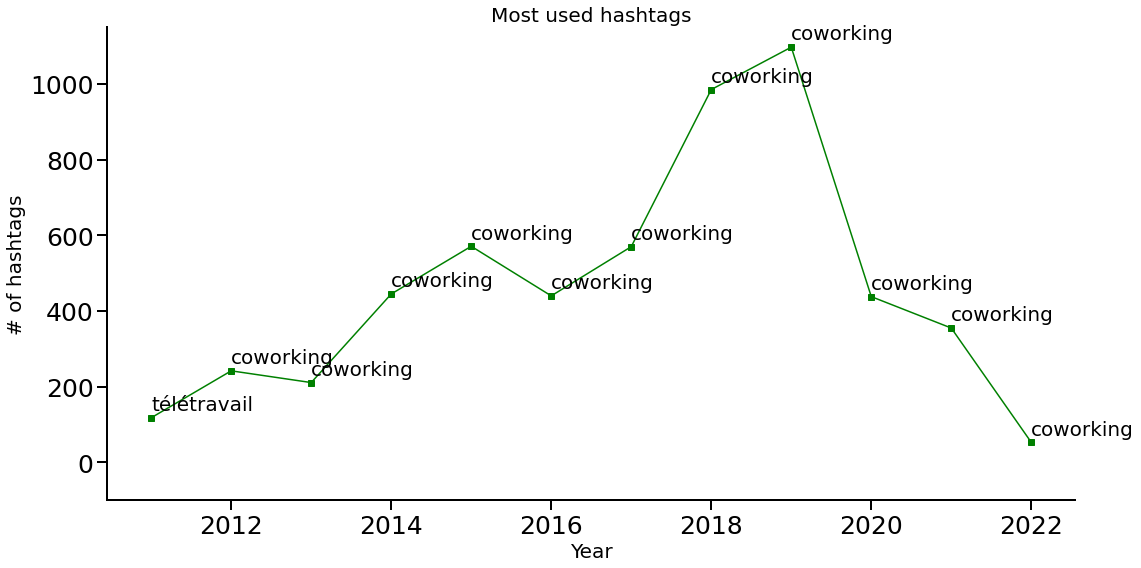

In [30]:

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years[1:],year_hashtag1_num_list,color='g',marker='s')

shift_ver = 20
shift_hor = 0.0
for i,year in enumerate(years[1:]):
    if i%2 == 0:
        ax.text(year-shift_hor,year_hashtag1_num_list[i]+shift_ver,year_hashtag1_list[i],fontsize=20)
    else:
        ax.text(year+shift_hor,year_hashtag1_num_list[i]+shift_ver,year_hashtag1_list[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('# of hashtags',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-100)
ax.set_title('Most used hashtags',fontsize=20)

plt.tight_layout()
plt.savefig('hashtags_first_time.jpeg', dpi=100)

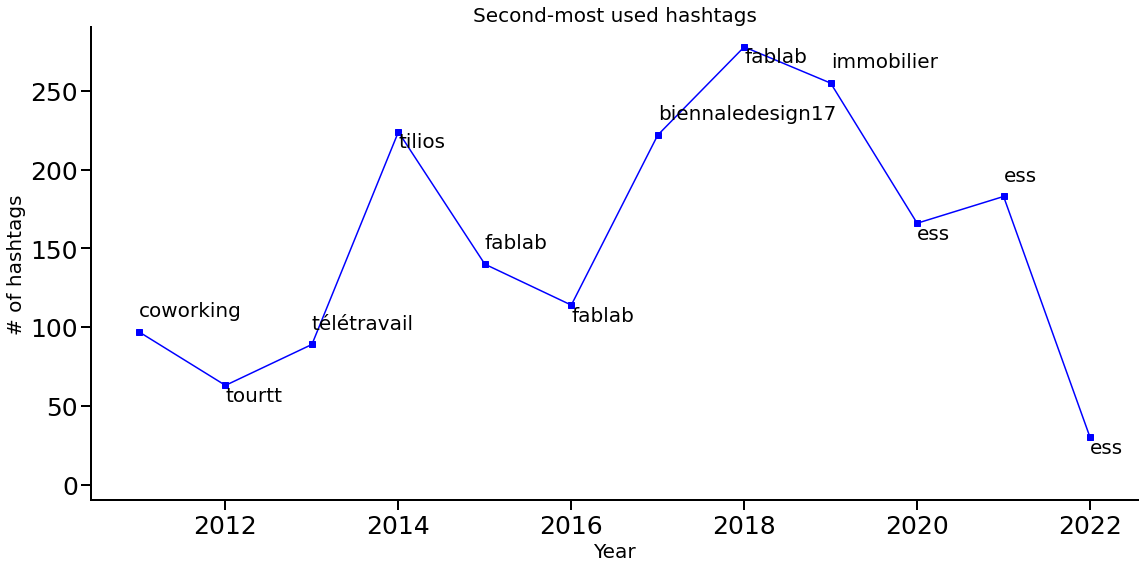

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(years[1:],year_hashtag2_num_list,color='b',marker='s')

shift_ver = 10
shift_hor = 0.0
for i,year in enumerate(years[1:]):
    if i%2 == 0:
        ax.text(year-shift_hor,year_hashtag2_num_list[i]+shift_ver,year_hashtag2_list[i],fontsize=20)
    else:
        ax.text(year-shift_hor,year_hashtag2_num_list[i]-shift_ver,year_hashtag2_list[i],fontsize=20)

ax.set_xlabel('Year',fontsize=20)
ax.set_ylabel('# of hashtags',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)
ax.set_ylim(ymin=-10)
ax.set_title('Second-most used hashtags',fontsize=20)

plt.tight_layout()
plt.savefig('hashtags_second_time.jpeg', dpi=100)